In [1]:
# Essential Libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from totem_utils import pixel_to_yolo, yolo_to_pixel
import shutil
import glob

import os
import pickle
from PIL import Image
from transformers import ViTFeatureExtractor, ViTModel

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# Display plots inline
%matplotlib inline

# Set plot parameters
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['axes.grid'] = False
plt.style.use('dark_background')
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15

- Takes care of moving the files from the roboflow download folder
- Renames, resizes etc. if specified.
- Returns a .csv that can be used to read in stuff easily 
- ie. with a column for resized_filepath, renamed_filepath and so on

In [2]:
# DATASET VERSION
_version_ = 12

# Create target directories
# DATASET_ROOT_DIR = "./totem-data/"
# DATASET_VERSION = f"v{_version_}/"
# DATASET_VID = f"{DATASET_ROOT_DIR}/{DATASET_VERSION}/videos/"  # clearly i have to put that in manuallly....
# DATASET_IMAGES = f"{DATASET_VID}/images/"

# os.makedirs(DATASET_VID, exist_ok=True)
# os.makedirs(DATASET_IMAGES, exist_ok=True)

# original data doesnt have to do with annotated datsa

In [3]:
# ROBOFLOW
# Annotated dataset
PROJECT_NAME = "totem-tracker"
ROBOFLOW_DOWNLOAD_DIR = "./data/roboflow-dataset-download/"

dataset_download_path = os.path.join(ROBOFLOW_DOWNLOAD_DIR, f"{PROJECT_NAME}.v{_version_}i.yolov7pytorch/")
subdirs = ["train", "valid", "test"]
all_files_txt = sorted(glob.glob(dataset_download_path + '/**/*.txt', recursive=True)[2:])
all_files_jpg = sorted(glob.glob(dataset_download_path + '/**/*.jpg', recursive=True))
print(len(all_files_txt), len(all_files_jpg), all_files_jpg[:5])

# ['./roboflow-dataset-download/totem-tracker.v12i.yolov7pytorch/README.roboflow.txt',
#  './roboflow-dataset-download/totem-tracker.v12i.yolov7pytorch/README.dataset.txt',
#  './roboflow-dataset-download/totem-tracker.v12i.yolov7pytorch/valid/labels/fusion-16_mp4-196_jpg.rf.3880616547ba3591faf41b257e1e7f56.txt',
#  './r

1277 1277 ['./data/roboflow-dataset-download/totem-tracker.v12i.yolov7pytorch/test/images/IMG_4318_mov-11_jpg.rf.909bff19cbe7c7917eab5421211fb251.jpg', './data/roboflow-dataset-download/totem-tracker.v12i.yolov7pytorch/test/images/IMG_4318_mov-32_jpg.rf.229758b3d7c215f4400e8986ec0e7df2.jpg', './data/roboflow-dataset-download/totem-tracker.v12i.yolov7pytorch/test/images/IMG_4318_mov-48_jpg.rf.7bffd342197b8fa76e246f04dbced1d6.jpg', './data/roboflow-dataset-download/totem-tracker.v12i.yolov7pytorch/test/images/IMG_4318_mov-65_jpg.rf.773ae84d0338cff2fb56852552940472.jpg', './data/roboflow-dataset-download/totem-tracker.v12i.yolov7pytorch/test/images/IMG_4318_mov-8_jpg.rf.9c5a4b0069028986b794dfc151be86ba.jpg']


In [4]:
df = []

for txt, jpg in zip(all_files_txt, all_files_jpg):
    frame_name = txt.split(dataset_download_path)[-1].split("/")[-1]
    split_folder = txt.split(dataset_download_path)[-1].split("/")[:2]
    txt_oripath, jpg_oripath = txt, jpg
    #print(frame_name, split_folder, txt_oripath, jpg_oripath)
    
    if len(frame_name.split("_mov-")) == 2:
        cname = frame_name.split("_jpg")[0]
        dkey = cname.split("_mov-")[0]
        cnumber = int(cname.split("_mov-")[-1])
        tname = "frame_" + str(cnumber).zfill(4) + ".txt"
        jname = tname.replace("txt", "jpg")
        tpath = os.path.join(f"./data/dataset_v{_version_}", split_folder[1], split_folder[0], dkey, tname)
        df.append([split_folder[1], split_folder[0], dkey, jname, jpg_oripath, tname,  txt_oripath, tpath])

    elif len(frame_name.split("_mp4-")) == 2:
        cname = frame_name.split("_jpg")[0]
        dkey = cname.split("_mp4-")[0]
        try:
            cnumber = int(cname.split("_mp4-")[-1])
            tname = "frame_" + str(cnumber).zfill(4) + ".txt"
            jname = tname.replace("txt", "jpg")
            tpath = os.path.join(f"./data/dataset_v{_version_}", split_folder[1], split_folder[0], dkey, tname)
            df.append([split_folder[1], split_folder[0], dkey, jname, jpg_oripath, tname,  txt_oripath, tpath])
        except ValueError:
            continue

    else:
        cname = frame_name.split("_jpg")[0]
        dkey = "frame"
        try:
            cnumber = int(cname.split("frame_")[-1])
            tname = "frame_" + str(cnumber).zfill(4) + ".txt"
            jname = tname.replace("txt", "jpg")
            tpath = os.path.join(f"./data/dataset_v{_version_}", split_folder[1], split_folder[0], dkey, tname)
            df.append([split_folder[1], split_folder[0], dkey, jname, jpg_oripath, tname,  txt_oripath, tpath])
        except ValueError:
            continue


# DATFRAME 
columns = [
    "type", "split", "totem-id",
    "img-frame-name", "ori-img-fpath", 
    "txt-frame-name", "ori-txt-fpath", "target-txt-fpath"]

# DATAFRAME, SAVED
df = pd.DataFrame(df, columns=columns)
df["target-img-fpath"] = df["target-txt-fpath"].str.replace("txt", "jpg")
df["target-img-fpath"] = df["target-img-fpath"].str.replace("labels", "images")
print(len(df))
df.to_csv(f"./data/dataset_v{_version_}/totem_video_dataset.csv", index=False)


1268


In [5]:

df = pd.read_csv(f"./data/dataset_v{_version_}/totem_video_dataset.csv")
print(len(df))
df.head()

1268


,type,split,totem-id,img-frame-name,ori-img-fpath,txt-frame-name,ori-txt-fpath,target-txt-fpath,target-img-fpath
0,labels,test,IMG_4318,frame_0011.jpg,./data/roboflow-dataset-download/totem-tracker...,frame_0011.txt,./data/roboflow-dataset-download/totem-tracker...,./data/dataset_v12/labels/test/IMG_4318/frame_...,./data/dataset_v12/images/test/IMG_4318/frame_...
1,labels,test,IMG_4318,frame_0032.jpg,./data/roboflow-dataset-download/totem-tracker...,frame_0032.txt,./data/roboflow-dataset-download/totem-tracker...,./data/dataset_v12/labels/test/IMG_4318/frame_...,./data/dataset_v12/images/test/IMG_4318/frame_...
2,labels,test,IMG_4318,frame_0048.jpg,./data/roboflow-dataset-download/totem-tracker...,frame_0048.txt,./data/roboflow-dataset-download/totem-tracker...,./data/dataset_v12/labels/test/IMG_4318/frame_...,./data/dataset_v12/images/test/IMG_4318/frame_...
3,labels,test,IMG_4318,frame_0065.jpg,./data/roboflow-dataset-download/totem-tracker...,frame_0065.txt,./data/roboflow-dataset-download/totem-tracker...,./data/dataset_v12/labels/test/IMG_4318/frame_...,./data/dataset_v12/images/test/IMG_4318/frame_...
4,labels,test,IMG_4318,frame_0008.jpg,./data/roboflow-dataset-download/totem-tracker...,frame_0008.txt,./data/roboflow-dataset-download/totem-tracker...,./data/dataset_v12/labels/test/IMG_4318/frame_...,./data/dataset_v12/images/test/IMG_4318/frame_...


# MOVE DATA
- 1) move the files! loose some OLD columns and save that dataframe
- 3) save the individual totem-id dataframes
- 2) but maybe FIRST get the bboxes from the .txt files > actually it is cool if I canput the bbox coords into the dataframe for n-objects

In [6]:
unique_dir_paths = list(np.unique([x[0] for x in df["target-img-fpath"].str.split("frame_")]))
for upath in unique_dir_paths:
    os.makedirs(upath, exist_ok=True)

unique_dir_paths = list(np.unique([x[0] for x in df["target-txt-fpath"].str.split("frame_")]))
for upath in unique_dir_paths:
    os.makedirs(upath, exist_ok=True)

# Move files roboflow download > ./data/dataset_{_version_}/

In [7]:
# pytorch/valid/images
# pytorch/train/images
# pytorch/test/images
move_files = True

if move_files:
    for ori, target in zip(df["ori-img-fpath"].tolist(), df["target-img-fpath"].tolist()):
        #print(ori, ">>>", target)
        shutil.copyfile(ori, target)  # shutil.move(ori, target)

    for ori, target in zip(df["ori-txt-fpath"].tolist(), df["target-txt-fpath"].tolist()):
        shutil.copyfile(ori, target)


# Create the building blocks to produce cutouts (bounding box coords) from images
- Create the folder structure as far as possible before.
- think about storing the "class-id-key" in the df upfront?!
- now this generates a image cutout sequence that is consecutive for most totems
- have n=2 vids where n=2 totems were annotated > so this counts for 2 totems although its two videos
- otherwise there is a one to one correspondence of n=1 video file n=X totems for each video (ranging from 0/1 to 4 totems for one video)

In [8]:
df["target-img-bbox-cut-fpath"] = df["target-img-fpath"].str.replace("images/", "cutouts/").tolist()
df["target-img-bbox-cut-fpath"] = df["target-img-bbox-cut-fpath"].str.replace("test/", "")
df["target-img-bbox-cut-fpath"] = df["target-img-bbox-cut-fpath"].str.replace("valid/", "")
df["target-img-bbox-cut-fpath"] = df["target-img-bbox-cut-fpath"].str.replace("train/", "")
#df["target-img-bbox-cut-fpath"]  # then produce path vid_keys, bbox, frame on the fly...

In [9]:
llength = []
coll = dict()
line_counter = 0
annot_paths, image_paths, cutout_paths, vid_keys = df["target-txt-fpath"].tolist(), df["target-img-fpath"].tolist(), df["target-img-bbox-cut-fpath"].tolist(), df["totem-id"].tolist()
empty_counter = 0
# Relook empty_counter
class_ids = []
produce_image_cutouts = True

if produce_image_cutouts:

    for ith, (apath, ipath, cpath, vkey) in enumerate(zip(annot_paths, image_paths, cutout_paths, vid_keys)):
        # image parameters needed!
        img = Image.open(ipath)
        img_width, img_height = img.size

        with open(apath, "r") as f:
            # how many "rows/labels"
            lines = f.read().splitlines()
            #if the length is = 0 this might be un-annotated files or images without a totem
            coll[str(ith)] = {"length" : len(lines)}

            for nth, line in enumerate(lines):
                line_counter += 1
                cline = line.strip().split()

                # CONDITION 1 - do nothing if its empty, filter out later and re-look
                if not len(cline):
                    coll[str(ith)] = {str(nth) : 0}  
                    empty_counter += 1
                    class_ids.append("NaN")

                # CONDITION 2 - Bounding boxes
                elif len(cline) == 5:
                    coll[str(ith)] = {str(nth) : "bbox"}# [nth].append(True)
                    coll[str(ith)] = {"bbox_" + str(nth) : cline[1:]}

                    cline_floats = [float(cl) for cl in cline[1:]]
                    x_left, y_top, x_right, y_bottom = yolo_to_pixel(cline_floats[0], cline_floats[1], cline_floats[2], cline_floats[3], img_width, img_height)
                    bbox_coords = (x_left, y_top, x_right, y_bottom)

                    # LOGGING / CHECKING
                    # print("Bounding Box Coordinates:", bbox_coords)
                    # print("Image Size (W, H):", img.size)
                    # if bbox_coords[0] < 0 or bbox_coords[1] < 0 or bbox_coords[2] > img_width or bbox_coords[3] > img_height:
                    #     print("Error: Bounding box extends outside the image")
                    # else:
                    #     print("Bounding box is inside the image")

                    # Generate CUTCOUT
                    class_ids.append(cline[0])
                    save_path = "/".join(cpath.split("/")[:-1]) + f"/bbox{cline[0]}/"  # f"/bbox{nth}/"  # + cpath.split("/")[-1]
                    save_file = save_path + cpath.split("/")[-1]
                    os.makedirs(save_path, exist_ok=True)
                    bbox_image = img.crop(bbox_coords)
                    bbox_image.save(save_file, "JPEG", quality=100)

                # CONDITION 3 - Segmentations mask
                else:
                    coll[str(ith)] = {str(nth) : "segmask"}
                    values = cline[1:]
                    x_values = []
                    y_values = []
                    while values and len(values) >= 2:
                        x_values.append(values.pop(0))
                        y_values.append(values.pop(0))
                
                    minmax_x = [min([float(x) for x in x_values]), max([float(x) for x in x_values])]
                    minmax_y = [min([float(y) for y in y_values]), max([float(y) for y in y_values])]
                    x_center, y_center = np.mean(minmax_x), np.mean(minmax_y)
                    width, height = np.diff(minmax_x)[0], np.diff(minmax_y)[0]

                    x_left, y_top, x_right, y_bottom = yolo_to_pixel(x_center, y_center, width, height, img_width, img_height)
                    bbox_coords = (x_left, y_top, x_right, y_bottom)

                    # Generate CUTCOUT
                    class_ids.append(cline[0])
                    save_path = "/".join(cpath.split("/")[:-1]) + f"/bbox{cline[0]}/"
                    save_file = save_path + cpath.split("/")[-1]
                    os.makedirs(save_path, exist_ok=True)
                    bbox_image = img.crop(bbox_coords)
                    bbox_image.save(save_file, "JPEG", quality=100)

empty_counter

0

In [10]:
totem_dir = f"./data/dataset_v{_version_}/cutouts/totem-ids/"
totem_directories = sorted([os.path.join(totem_dir, f) for f in os.listdir(totem_dir) if not f.startswith(".")])

cstring = ["totem" + str(n).zfill(2) for n in range(1,13)] + ["totem13a", "totem14a", "totem13b", "totem14b"]
coll = dict()

img_for_feature_extraction = True
if img_for_feature_extraction:
    for tdir, cstr in zip(totem_directories, cstring):
        if os.path.isdir(tdir):
            coll[cstr] = sorted([os.path.join(tdir, f) for f in os.listdir(tdir) if f.endswith(".jpg")])


In [11]:
# Feature extraction setup
feature_extraction = True
if feature_extraction:
    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
    model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k', return_dict=True)
    # unicom-feature extract
    # introduce batching! once we have it as a hf dataset

    for k, v in coll.items():
        # Perform feature extraction
        feature_vectors = []
        for i, image in enumerate(v): 
            image = Image.open(image)
            inputs = feature_extractor(images=image, return_tensors="pt")
            outputs = model(**inputs)
            feature_vector = outputs.pooler_output.detach().cpu().numpy()
            feature_vectors.append(feature_vector)  # feature_vectors = torch.cat(feature_vectors)

        feature_vectors = np.concatenate(feature_vectors, axis=0)
        np.save(os.path.join(totem_dir, k, "feature_vector_file.npy"), feature_vectors)
        # time taken vit: 13min, 9min,
    

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# Produce videos of totems

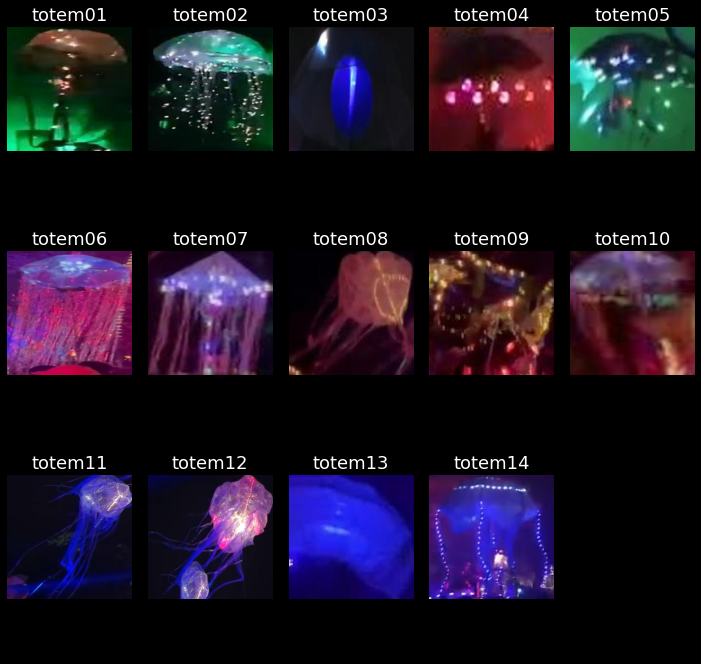

In [12]:
resized_images = []
for k, v in coll.items():
    if k == "totem13a":
        continue
    elif k == "totem14b":
        continue
    else:
        image = Image.open(v[20]).resize((256,256))
        resized_images.append(image)


#totem_str = ["totem" + str(n).zfill(2) for n in range(1,13)] + ["totem13a", "totem14a", "totem13b", "totem14b"]
totem_str = ["totem" + str(n).zfill(2) for n in range(1,13)] + ["totem13", "totem14"]
totem_ind = [int(n) for n in range(1,13)] + [14, 16]
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))
axes_flat = axes.flatten()
counter = 0

for ts, ax, img in zip(totem_str, axes_flat, resized_images):
    ax.imshow(img)    
    ax.axis('off')
    ax.set_title(ts, fontdict={"color" : "w"})
    counter += 1

axes_flat[-1].axis('off')
plt.tight_layout()
fig.savefig("./readme-images/Illustartion_Totems-1-14.jpg", dpi=300)

In [13]:
# resized_images = []
# for k, v in coll.items():
#     image = Image.open(v[20]).resize((224, 224))
#     resized_images.append(image)

# # Number of images
# num_images = len(resized_images)

# # Create a single row of subplots with 'num_images' number of columns
# fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(30, 30))

# # Loop through the resized images and axes to display images
# for ax, img in zip(axes, resized_images):
#     ax.imshow(img)
#     ax.axis('off')

# plt.tight_layout()
# fig.savefig("./readme-images/testsave_.jpg", dpi=300)

## Example Totems

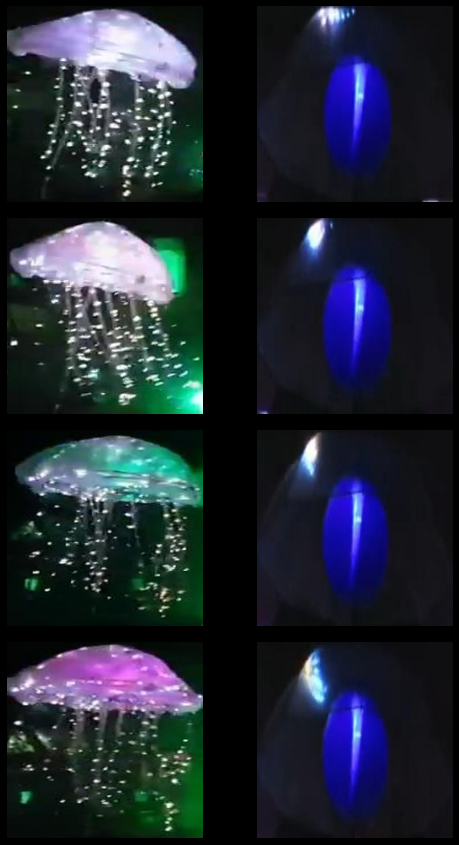

In [14]:
totem_ids = ["totem02", "totem03"]
to1 = coll[totem_ids[0]]
to2 = coll[totem_ids[1]]

time_points = [10, 15,20,25]  # [10, 90, 110, 130, 170] for 14ab
num_tps = len(time_points)
resized_images = []

for tp in time_points:
    t1, t2 = to1[tp], to2[tp]
    image1 = Image.open(t1).resize((224, 224))
    image2 = Image.open(t2).resize((224, 224))
    resized_images.extend([image1, image2])

num_images = len(resized_images)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 12))

for ax, img in zip(axes.flatten(), resized_images):
    #ax.title()
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
fig.savefig(f"./readme-images/example_totems_id{totem_ids[0]}_id{totem_ids[1]}-num_tps-{num_tps}.jpg", dpi=300)

In [15]:
# totem_tsne = dict()
# fv_list = []
# number_of_elements = []
# tsne = TSNE(n_components=2, perplexity=30, early_exaggeration=200, learning_rate=45, random_state=42, init="pca")  # 150, 200, 250

# for k in totem_ids:

#     totem_features = np.load(os.path.join(totem_dir, k, "feature_vector_file.npy"))
#     totem_tsne[k] = tsne.fit_transform(totem_features)  # indidivdual totems
#     fv_list.append(totem_features)
#     number_of_elements.append(totem_features.shape[0])

# fvs = np.concatenate(fv_list, axis=0)
# features_embedded = tsne.fit_transform(fvs)

# totem_indices = [0] + list(np.cumsum(number_of_elements))
# print(totem_indices)

In [16]:
# WORKS ONLY FOR SIMULTANEOUS OBSERVATIONS
# colors = ["w", "r"]
# plt.figure(figsize=(8,8))
# tvec, fembed = list(), list()
# for nth, c in enumerate(colors):
#     vec = np.arange(totem_indices[nth], totem_indices[nth+1])

#     if vec[0] == 179:
#         size = (vec - 179) + 5
#         tvec.append(vec-vec)
#     else:
#         size = vec + 5
#         tvec.append(vec)
#     fembed.append(features_embedded[vec, :])
#     plt.scatter(features_embedded[vec, 0], features_embedded[vec, 1], alpha=.7, color=c, s=size)
#     plt.scatter(np.mean(features_embedded[vec, 0]), np.mean(features_embedded[vec, 1]), alpha=1, color=c, marker="*", edgecolor="w", s=220)
    
# plt.tight_layout()
# plt.axis("square")
# plt.savefig(f"./readme-images/example_tSNE-totems_id{11}_id{12}.jpg", dpi=300)

# plt.figure(figsize=(7,3))
# plt.title("tSNE dim. 1")
# plt.plot(tvec[0], fembed[0][:,0] - np.mean(fembed[0][:,0]), "w", lw=2)
# plt.plot(tvec[0], fembed[1][:,0] - np.mean(fembed[1][:,0]), "r", lw=2)
# plt.xlabel("Frames")
# plt.ylabel("t-SNE dim. 1")

# plt.savefig(f"./readme-images/example_tSNE-versus-frames-totems_id{11}_id{12}.jpg", dpi=300)


# plt.figure(figsize=(7,3))
# plt.title("tSNE dim. 2")
# plt.plot(tvec[0], fembed[0][:,1] - np.mean(fembed[0][:,1]), "w", lw=2)
# plt.plot(tvec[0], fembed[1][:,1] - np.mean(fembed[1][:,1]), "r", lw=2)
# plt.xlabel("Frames")
# plt.ylabel("t-SNE dim. 2")

# cframes = [10, 90, 110, 130, 170]

# TSNE - Load and concat all feature vectors

### T-SNE

In [17]:

# T-SNE Setup with equal parameters
tsne = TSNE(n_components=2, perplexity=50, early_exaggeration=150, learning_rate=45, random_state=42, init="pca")  # 150, 200, 250

totem_tsne = dict()
fv_list = []
number_of_elements = []

for k in coll.keys():

    # Load and retain the extracted feature vectors per totem
    totem_features = np.load(os.path.join(totem_dir, k, "feature_vector_file.npy"))
    totem_tsne[k] = tsne.fit_transform(totem_features)  # indidivdual totems

    # Save
    fv_list.append(totem_features)
    number_of_elements.append(totem_features.shape[0])

# Pool feature vectors across totems and perform t-SNE
fvs = np.concatenate(fv_list, axis=0)
features_embedded = tsne.fit_transform(fvs)
totem_indices = [0] + list(np.cumsum(number_of_elements))
print(totem_indices)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initializatio

[0, 69, 138, 202, 393, 464, 519, 641, 756, 892, 974, 1153, 1332, 1363, 1499, 1634, 1876]


- it seems like from the original video file more frames were extracted then land in the roboflow annotated folder. because I havent annotated all of the frames?
- ie frame/ >n=106 elem, maybe I have overwritten some? or were not downloaded?
- ie JOB 7 7.7.23 > frames left un-annotated + i remember to have left some un-annotated because for the test set! however thats not how this works > test set has to be labeled!
- if theres no label file the copy/move function will not retain that file
- ie totem12 (PXL_20230701_001535797TS_mp4) has the correct number of frames and counts up to the highest number of frames
- or t-SNE doesnt work on low number of items ie n=69, only when combined with more vector become the patterns clear
- totem03, come from fusion-16 folder, seems to have correct number of frames too n=64
- early exgeration seems to play a role especially for doing it on individual tottems (n=242)


### T-SNE Vizualization

(1876, 768) 17 16


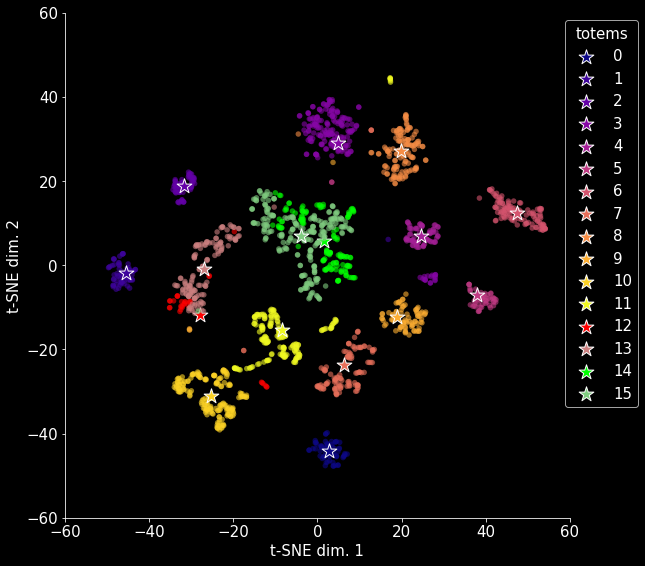

In [23]:
# Cmap
cmap = plt.cm.plasma
colors = cmap(np.linspace(0, 1, 12))
colors = np.append(colors, [[1.,0,0,1.], [.8,.5,.5,1.], [0,1.,0,1.], [.5,.8,.5,1.]], axis=0)  # , [1.,1.,1.,1.]
print(fvs.shape, len(totem_indices), len(colors))


plt.figure(figsize=(9,9))
for nth, c in enumerate(colors):
    vec = np.arange(totem_indices[nth], totem_indices[nth+1])
    plt.scatter(features_embedded[vec, 0], features_embedded[vec, 1], alpha=.6, color=c, s=30, edgecolor="none")
    plt.scatter(np.mean(features_embedded[vec, 0]), np.mean(features_embedded[vec, 1]), alpha=1, color=c, marker="*", edgecolor="w", s=240, label=int(nth))


plt.axis("square")
plt.xlim([-60, 60])#plt.tight_layout
plt.ylim([-60, 60])
plt.xlabel("t-SNE dim. 1")
plt.ylabel("t-SNE dim. 2")
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right', title="totems")
plt.tight_layout()
plt.savefig("./readme-images/t-SNE-totems-all.jpg", dpi=300)

# OR USE STRING BESIDES EACH MARKER TO IDENTIFY TOTEMS

# - rezise on read-in into 224x224 (assumed that this is was the feature_extractor uses) > these are the cutouts images, refer to those for each totem
# - first show an example image close to the mean (START with just the 20th image)
# - match frame with color for totem illustration
# - video for all of them (in original size and resized)
# - take totem13 and 14 as an examples (as they come from the same video just different time cut of that)
# - check out the two big ones and the fusion video with two fantastic ones!

(-54.83931045532226, 59.34504013061523, -52.31102466583252, 61.873325920104975)

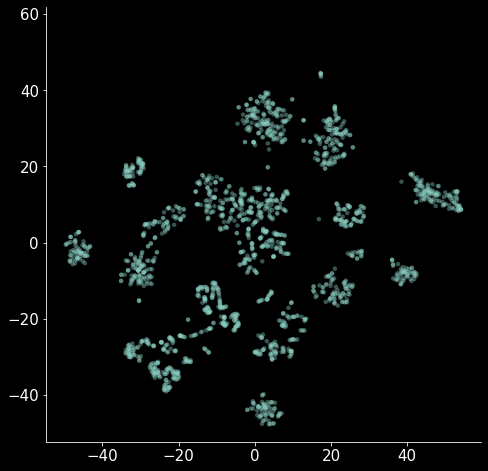

In [19]:
# Plot the reduced features
plt.figure(figsize=(8,8))
plt.scatter(features_embedded[:, 0], features_embedded[:, 1], alpha=.4, edgecolors="none", s=20)
plt.axis("square")

# Now restructure the dataset into totem-id counting upwards from 1, then load daata easily

# Split into individual totem id dataframes for flexibility later

In [20]:
# idx = df["totem-id"] == "VID-20230703-WA0028_beginning-cut" # "IMG_4318"
# df[idx].sort_values(by="img-frame-name")
# # reset_index()
